In [263]:
import numpy as np
import pandas as pd

## Use Mushroom dataset and sample 2000 rows from it.

In [264]:
data = pd.read_csv('agaricus-lepiota.data.csv', names=[str(i) for i in range(23)])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [265]:
data_sample = data.sample(n=2000)
df = data_sample.reset_index(drop=True)
print('Data Shape: %d %d' % df.shape)
df.head()

Data Shape: 2000 23


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,f,s,e,f,y,f,c,n,b,...,k,w,p,p,w,o,e,w,v,l
1,p,f,s,g,t,f,f,c,b,h,...,f,w,w,p,w,o,p,h,v,u
2,e,x,y,g,t,n,f,c,b,p,...,s,g,g,p,w,o,p,n,y,d
3,e,x,f,n,f,n,f,w,b,n,...,f,w,w,p,w,o,e,k,a,g
4,e,b,y,w,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,m


## Do some data preprocessing.

In [266]:
from sklearn.preprocessing import LabelEncoder

首先，先處理 categorical data。  
將各種不同的 categorical features 轉成 nominal features  

In [267]:
label_le = LabelEncoder()
feature_le = LabelEncoder()

In [268]:
# encode labels
df['0'] = label_le.fit_transform(df['0'].values)
# encode features
num_values = [] # for ohe
features = [str(i) for i in range(1, 23, 1)]
for i in features:
    df[i] = feature_le.fit_transform(df[i].values)
    class_list = feature_le.classes_.tolist() # 這個feature中有那些不同的class
    num_values.append(len(class_list))
    if '?' in class_list:
        idx = class_list.index('?')
        df[i] = df[i].replace(idx, np.nan)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,2,2,2,0,8,1,0,1,0,...,1,7,6,0,2,1,0,7,4,2
1,1,2,2,3,1,2,1,0,0,3,...,0,7,7,0,2,1,4,1,4,5
2,0,5,3,3,1,5,1,0,0,7,...,2,3,3,0,2,1,4,3,5,0
3,0,5,0,4,0,5,1,1,0,5,...,0,7,7,0,2,1,0,2,0,1
4,0,0,3,8,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,3


接著，處理 missing values。  
由於我們只 sample 了 2000 個 data，所以不一定會有 missing data。  
但如果有的話，若我們直接丟掉那些有 missing values 的 data 會讓本來就不多的 data 更少。因此，我選擇將這些 data 做 imputing。

In [269]:
from sklearn.preprocessing import Imputer

In [270]:
df.isnull().sum()

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11    592
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
dtype: int64

In [271]:
imr = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
data_imputed = imr.fit_transform(df.values)

df_imputed = pd.DataFrame(data_imputed)
df_imputed.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
dtype: int64

經過 imputing 後，我們就能做 one-hot encoding。

In [272]:
from sklearn.preprocessing import OneHotEncoder

In [273]:
features_idx = []
for i in features:
    features_idx.append(df_imputed.columns.tolist().index(int(i)))
    
ohe = OneHotEncoder(categorical_features=features_idx, sparse=False)

data_ohe = ohe.fit_transform(data_imputed)
print('Before Ohe: %d %d' % data_imputed.shape)
print('After Ohe: %d %d' % (data_ohe.shape))

Before Ohe: 2000 23
After Ohe: 2000 117


可以發現：features 數量增加了許多。

## Train models using KNN and/or SVM

先將 data 分成 training 和 testing set。

In [274]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [275]:
X = data_ohe[:, 1:]
y = data_ohe[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('Size of training set: %d, %d' % X_train.shape)
print('Size of testing set: %d, %d' % X_test.shape)

Size of training set: 1600, 116
Size of testing set: 400, 116


In [276]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

先試試看 KNN。  
我利用 validation set 去嘗試了從 1 到 100 的 nearest neighbor number，最好找出一個最好的結果來當作 KNN 的 hyperparameter。

In [277]:
# p=2 and metric='minkowski' means the Euclidean Distance
x_train, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
print('Size of training set: %d, %d' % x_train.shape)
print('Size of validation set: %d, %d' % x_val.shape)

Size of training set: 1280, 116
Size of validation set: 320, 116


Best NN number: 5
Best #misclassified samples of validation set: 10
Accuracy on validation set: 0.9688


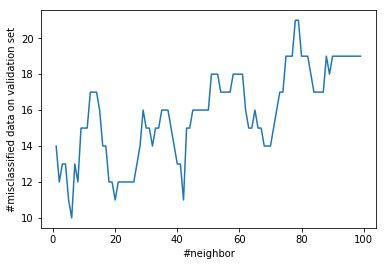

In [278]:
error = []
accuracy = []
for i in range(1, 100, 1):
    knn = KNeighborsClassifier(n_neighbors=i, p=2, metric='minkowski')
    knn.fit(x_train, y_tr)
    y_pred = knn.predict(x_val)
    error.append((y_val != y_pred).sum())
    accuracy.append(accuracy_score(y_val, y_pred))

best_nn = error.index(min(error)) # best nn according to validation set
print('Best NN number: %d' % best_nn)
print('Best #misclassified samples of validation set: %d' % min(error))
print('Accuracy on validation set: %.4f' % max(accuracy))

nn_num = range(1, 100, 1)
plt.plot(nn_num, error)
plt.xlabel('#neighbor')
plt.ylabel('#misclassified data on validation set')
plt.show()

將最好的 NN number 拿來 train and test。

In [280]:
knn = KNeighborsClassifier(n_neighbors=best_nn, p=2, metric='minkowski')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('[KNN]:')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[KNN]:
Misclassified samples: 11
Accuracy: 0.9725


In [281]:
# kernel: the kernel function, can be 'linear', 'poly', 'rbf', ...etc
# C is the hyperparameter for the error penalty term
svm_linear = SVC(kernel='linear', C=1000.0, random_state=0)

svm_linear.fit(X_train, y_train)
y_pred = svm_linear.predict(X_test)
print('[Linear SVC]:')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[Linear SVC]:
Misclassified samples: 0
Accuracy: 1.0000


In [282]:
svm_rbf = SVC(kernel='rbf', random_state=0, gamma=0.2, C=10.0)

svm_rbf.fit(X_train, y_train)
y_pred = svm_rbf.predict(X_test)
print('[Nonlinear SVC]:')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))


[Nonlinear SVC]:
Misclassified samples: 1
Accuracy: 0.9975


從實驗結果可以發現：linear 和 nonlinear 的 SVC 表現最好。